# Smarter HP Search for Muon Iterators

by Franz Louis Cesista

Crucial insights:
- The variance of the singular values after the iterations don't really matter much, only that the grad at 0 is very high.
- We can increase the grad at zero either by increasing $\gamma$ or $r$
- But there is a maximum viable $\gamma$ for a given $r$ because (1) the peak of the iterator within $(0, 1-l]$ must be $<= 1 + r$ and (2) the trough within $[1-l, 1]$ must be $> 0$.
  - There is also a minimum viable $\gamma$ for a given $r$ because we want to push non-zero singular values to $\pm 1$. To do that, $f(x) > x$ for $0 < x <= 1-l$.

## Prepare utilities

### Import libraries

In [1]:
import jax.numpy as jnp
import sympy as sp
from scipy.optimize import bisect

import matplotlib.pyplot as plt
import seaborn as sns

### Prepare sympy symbols or symbolic proofs/manipulation later on

In [2]:
# Note: we use sympy for symbolic manipulation

gamma_ = sp.Symbol("gamma", interval=(0, sp.S.Infinity), left_open=True, right_open=True)
l_ = sp.Symbol("l", interval=(0, 1), left_open=False, right_open=True)
r_ = sp.Symbol("r", interval=(0, 1), left_open=False, right_open=True)
x_ = sp.Symbol("x", real=True)

# We want to estimate sign(M) +- epsilon
fp_ = [1 - l_, 1 + r_, 0, -(1 + r_), -(1 - l_)]
iterator_ = x_ + gamma_ * (x_ - fp_[0])*(x_ - fp_[1])*(x_ - fp_[2])*(x_ - fp_[3])*(x_ - fp_[4])
iterator_simplified_ = sp.collect(sp.expand(iterator_), x_)

dhdx_ = sp.simplify(sp.expand(sp.diff(iterator_simplified_, x_, real=True)))
dhdx_ = dhdx_.refine(sp.Q.real(x_)).refine(sp.Q.real(gamma_)).refine(sp.Q.real(l_)).refine(sp.Q.real(r_))
dhdx_ = sp.collect(sp.simplify(dhdx_), x_)

In [3]:
iterator_jax = sp.lambdify((x_, gamma_, l_, r_), iterator_simplified_, "jax")
dhdx_jax = sp.lambdify((x_, gamma_, l_, r_), dhdx_, "jax")

### Utils

In [4]:
def get_iterator_stats(gamma: float, l: float, r: float) -> tuple[float, float]:
    critical_points = sp.nroots(dhdx_.subs({gamma_: gamma, l_: l, r_: r}))
    critical_point_values = [
        critical_point.evalf()
        for critical_point in critical_points
        if critical_point.as_real_imag()[1] == 0
    ]
    critical_point_values = sorted(critical_point_values)

    if len(critical_point_values) == 0:
        peak_x, trough_x = 1 - l, 1 - l
    elif len(critical_point_values) == 2:
        peak_x = critical_point_values[1]
        trough_x = critical_point_values[1]
    else:
        peak_x = critical_point_values[2]
        trough_x = critical_point_values[3]

    return iterator_jax(peak_x, gamma, l, r), iterator_jax(trough_x, gamma, l, r)

In [5]:
def find_best_gamma_for_radius_util(
    gamma: float,
    radius_inner: float,
    radius_outer: float,
    gamma_eps: float = 1e-4,
):
    peak, trough = get_iterator_stats(gamma, radius_inner, radius_outer)
    peak, trough = jnp.float32(peak), jnp.float32(trough)
    # The peak in the range (0, 1-l] must be <= 1 + r; and
    # The trough in the range [1-l, 1+r] must be >= 0
    return min((1 + radius_outer - gamma_eps) - peak, trough - gamma_eps)


def find_best_gamma_for_radius(
    radius_inner: float,
    radius_outer: float,
    gamma_min: float = 0.1,
    gamma_max: float = 5.0,
    gamma_eps: float = 1e-4,
) -> float:
    f = lambda gamma: find_best_gamma_for_radius_util(
        gamma, radius_inner, radius_outer, gamma_eps
    )

    return bisect(f, gamma_min, gamma_max, xtol=gamma_eps, rtol=gamma_eps)

In [6]:
def grad_at_0(l: float, r: float):
    gamma = find_best_gamma_for_radius(l, r, gamma_max=5)
    return dhdx_jax(0, gamma, l, r)

## Main work

### Proof that (1) increasing $r$ and $\gamma$ increases the grad at 0 and (2) the optimal $l$ is $0$

First, let's take the derivative of the (generalized) iterator at $x=0$

In [7]:
sp.collect(sp.expand(dhdx_.subs({x_: 0})), gamma_)

gamma*(l**2*r**2 + 2*l**2*r + l**2 - 2*l*r**2 - 4*l*r - 2*l + r**2 + 2*r + 1) + 1

Note from above that that increasing $\gamma$ increases the derivative at 0. We only need to analyze the terms in the parenthesis:

In [8]:
sp.factor((dhdx_.subs({x_: 0}) - 1) / gamma_)

(l - 1)**2*(r + 1)**2

First, notice that increasing $r$ always increases the derivative at 0. Secondly, since $0 \leq l < 1$, the term $(l - 1)^2$ decreases as we increase $l$. Thus, the optimal $l$ is 0.

### Find optimal $r$ and $\gamma$ given that $l = 0.1$

In [9]:
l = 0.1

In [10]:
rs = jnp.linspace(0.05, 1, 20)
grads = jnp.array([grad_at_0(l, r) for r in rs])

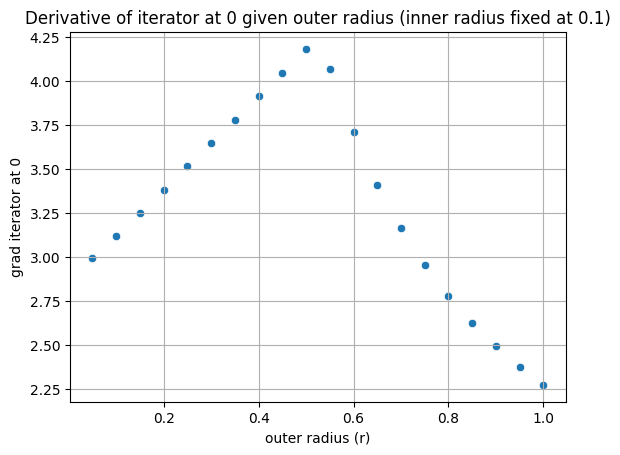

In [11]:
sns.scatterplot(x=rs, y=grads)
plt.title(f"Derivative of iterator at 0 given outer radius (inner radius fixed at {l})")
plt.xlabel("outer radius (r)")
plt.ylabel("grad iterator at 0")
plt.grid()
plt.savefig(f"img/grads_at_x=0--l={l}.png")

In [12]:
best_r = rs[jnp.argmax(grads)]
best_gamma = find_best_gamma_for_radius(l, best_r, gamma_max=5)
dhdx_0 = dhdx_jax(0, best_gamma, l, best_r)
l, best_r, best_gamma, dhdx_0

(0.1,
 Array(0.5, dtype=float32),
 1.7459442138671877,
 Array(4.1819835, dtype=float32))

### Find optimal $r$ and $\gamma$ given that $l = 0.25$

In [13]:
l = 0.25

In [ ]:
rs = jnp.linspace(0.05, 1, 20)
grads = jnp.array([grad_at_0(l, r) for r in rs])

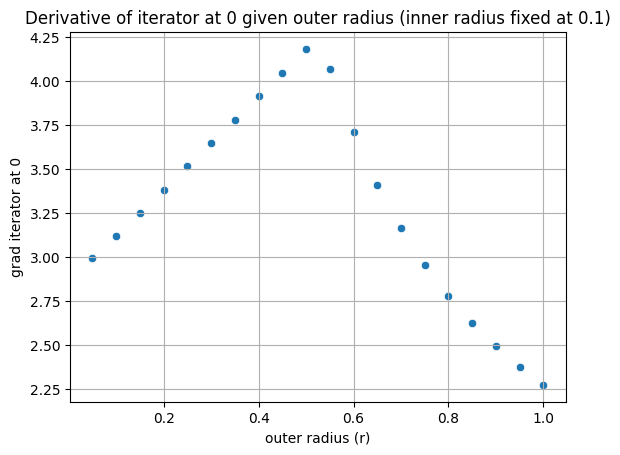

In [ ]:
sns.scatterplot(x=rs, y=grads)
plt.title(f"Derivative of iterator at 0 given outer radius (inner radius fixed at {l})")
plt.xlabel("outer radius (r)")
plt.ylabel("grad iterator at 0")
plt.grid()
plt.savefig(f"img/grads_at_x=0--l={l}.png")

In [ ]:
best_r = rs[jnp.argmax(grads)]
best_gamma = find_best_gamma_for_radius(l, best_r, gamma_max=5)
dhdx_0 = dhdx_jax(0, best_gamma, l, best_r)
l, best_r, best_gamma, dhdx_0

(0.1,
 Array(0.5, dtype=float32),
 1.7459442138671877,
 Array(4.1819835, dtype=float32))

### Find optimal $r$ and $\gamma$ given that $l = 0$

In [44]:
l = 0

In [45]:
rs = jnp.linspace(0.05, 1, 20)
grads = jnp.array([grad_at_0(l, r) for r in rs])

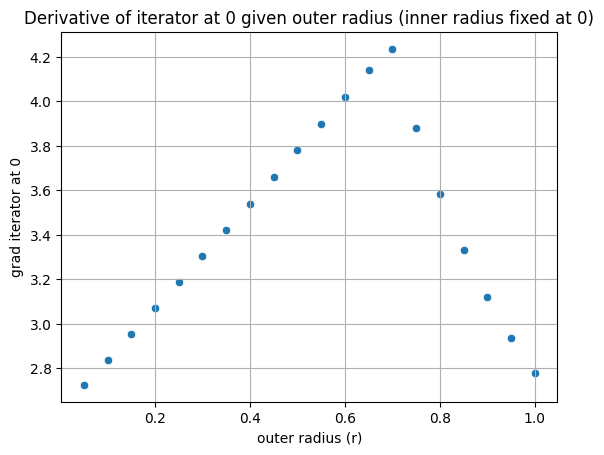

In [46]:
sns.scatterplot(x=rs, y=grads)
plt.title(f"Derivative of iterator at 0 given outer radius (inner radius fixed at {l})")
plt.xlabel("outer radius (r)")
plt.ylabel("grad iterator at 0")
plt.grid()
plt.savefig(f"img/grads_at_x=0--l={l}.png")

In [47]:
best_r = rs[jnp.argmax(grads)]
best_gamma = find_best_gamma_for_radius(l, best_r, gamma_max=5)
dhdx_0 = dhdx_jax(0, best_gamma, l, best_r)
l, best_r, best_gamma, dhdx_0

(0,
 Array(0.7, dtype=float32),
 1.1196868896484378,
 Array(4.235895, dtype=float32))

### Get coefficients for iterator found above

In [29]:
my_iterator = iterator_simplified_.subs({gamma_: best_gamma, l_: l, r_: best_r})
print(my_iterator)

pkj = sp.Poly(my_iterator, x_)
coeffs = [round(coeff, 4) for coeff in pkj.coeffs()]
print(f"{coeffs = }")

1.11968688964844*x**5 - 4.35558195535022*x**3 + 4.23589506570178*x
coeffs = [1.1197, -4.3556, 4.2359]


### Check the derivatives at $x=0$

In [33]:
d0 = sp.diff(my_iterator, x_).subs({x_: 0})
d0

4.23589506570178

With $n$ iterations, this would then be:

In [34]:
n = 5
d0**n

1363.72237055349

### Plot iterator found above

In [35]:
from functools import partial

my_iterator_jax = partial(iterator_jax, gamma=best_gamma, l=l, r=best_r)

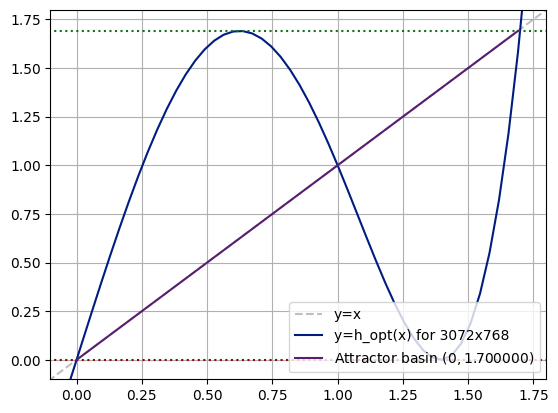

In [40]:
x = jnp.linspace(-(1 + best_r + 0.1), 1 + best_r + 0.1, 100)

palette = sns.color_palette("dark6")

sns.lineplot(x=x, y=x, label='y=x', color="black", linestyle="--", alpha=0.25)

i = 0
in_features, out_features = (768, 3072)
y_ = my_iterator_jax(x)
sns.lineplot(x=x, y=y_, label=f"y=h_opt(x) for {out_features}x{in_features}", color=palette[0])

peak, trough = get_iterator_stats(best_gamma, l, best_r)
peak, trough = float(peak), float(trough)

y_ = jnp.full(x.shape, float(peak))
sns.lineplot(x=x, y=y_, color=palette[1], linestyle=":")
y_ = jnp.full(x.shape, float(trough))
sns.lineplot(x=x, y=y_, color=palette[2], linestyle=":")

x = jnp.linspace(trough, peak, 100)
sns.lineplot(x=x, y=x, label=f"Attractor basin $(0, {1+best_r:1f})$", color=palette[3])

plt.xlim(-(0.1), 1 + best_r + 0.1)
plt.ylim(-(0.1), 1 + best_r + 0.1)
plt.grid()
plt.legend(loc="lower right")
plt.savefig("img/iterator_attractor_basin.png")

### MISC

In [76]:
iterator__ = iterator_simplified_  #.subs({l_: 0})
iterator__

gamma*x**5 + x**3*(-gamma*l**2 + 2*gamma*l - gamma*r**2 - 2*gamma*r - 2*gamma) + x*(gamma*l**2*r**2 + 2*gamma*l**2*r + gamma*l**2 - 2*gamma*l*r**2 - 4*gamma*l*r - 2*gamma*l + gamma*r**2 + 2*gamma*r + gamma + 1)

In [77]:
# composed_iterator_ = x_
# 
# for _ in range(3):
#     composed_iterator_ = sp.compose(composed_iterator_, iterator__)
#     composed_iterator_ = sp.collect(sp.expand(composed_iterator_), x_)
# 
# composed_iterator_

In [78]:
composed_dhdx_ = sp.simplify(sp.expand(sp.diff(iterator__, x_, real=True)))
composed_dhdx_ = composed_dhdx_.refine(sp.Q.real(x_)).refine(sp.Q.real(gamma_)).refine(sp.Q.real(l_)).refine(sp.Q.real(r_))
composed_dhdx_ = sp.collect(sp.simplify(composed_dhdx_), x_)
composed_dhdx_

gamma*l**2*r**2 + 2*gamma*l**2*r + gamma*l**2 - 2*gamma*l*r**2 - 4*gamma*l*r - 2*gamma*l + gamma*r**2 + 2*gamma*r + 5*gamma*x**4 + gamma + x**2*(-3*gamma*l**2 + 6*gamma*l - 3*gamma*r**2 - 6*gamma*r - 6*gamma) + 1

In [84]:
dhdx_0 = dhdx_.subs({x_: 0, l_: 0, r_: 0, gamma_: 0})
float(dhdx_0)
# sp.simplify(sp.expand(dhdx_0, r_, real=True))

1.0